In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=3, suppress=True)

### Examining goodness of fit of our model


#### Challenger Disaster Model





In [5]:
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

---

### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data (which if we recall is a *fixed* stochastic variable) with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

Previously in this Chapter, we simulated artificial dataset for the SMS example. To do this, we sampled values from the priors. We saw how varied the resulting datasets looked like, and rarely did they mimic our observed dataset. In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to create a new `Stochastic` variable, that is exactly the same as our variable that stored the observations, but minus the observations themselves. If you recall, our `Stochastic` variable that stored our observed data was:

    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)

Hence we create:
    
    simulated_data = pm.Bernoulli("simulation_data", p)

Let's simulate 10 000:

In [6]:
import pymc3 as pm
import theano.tensor as tt

N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_sim]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:24<00:00, 851.23draws/s]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


(20000, 23)


Text(0.5, 0.98, 'Simulated dataset using posterior parameters')

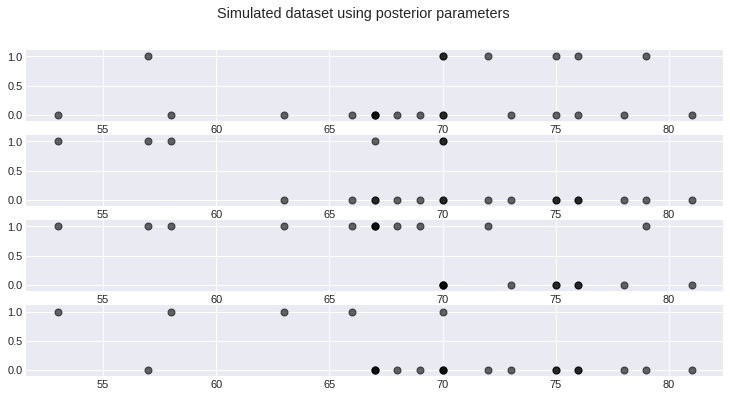

In [15]:
simulations = trace["bernoulli_sim"]
print(simulations.shape)

fig, axes = plt.subplots(4, 1, figsize=(12.5, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(temperature, simulations[1000*i, :], 
               color="k", s=50, alpha=0.6)
    
fig.suptitle("Simulated dataset using posterior parameters")

Note that the above plots are different (if you can think of a cleaner way to present this, please send a pull request and answer [here](http://stats.stackexchange.com/questions/53078/how-to-visualize-bayesian-goodness-of-fit-for-logistic-regression)!).

We wish to assess how good our model is. "Good" is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. The alternative is to use *Bayesian p-values*. These are still subjective, as the proper cutoff between good and bad is arbitrary. Gelman emphasises that the graphical tests are more illuminating [7] than p-value tests. We agree.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*[8]. For a suite of models we wish to compare, each model is plotted on an individual separation plot. I leave most of the technical details about separation plots to the very accessible [original paper](http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf), but I'll summarize their use here.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [58]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

posterior prob of defect | realized defect 
0.40                     |   0
0.25                     |   1
0.28                     |   0
0.32                     |   0
0.36                     |   0
0.19                     |   0
0.17                     |   0
0.25                     |   0
0.73                     |   1
0.53                     |   1
0.25                     |   1
0.10                     |   0
0.36                     |   0
0.80                     |   1
0.36                     |   0
0.13                     |   0
0.25                     |   0
0.07                     |   0
0.12                     |   0
0.09                     |   0
0.13                     |   1
0.12                     |   0
0.71                     |   1


Next we sort each column by the posterior probabilities:

In [59]:
ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

probb | defect 
0.07  |   0
0.09  |   0
0.10  |   0
0.12  |   0
0.12  |   0
0.13  |   1
0.13  |   0
0.17  |   0
0.19  |   0
0.25  |   1
0.25  |   0
0.25  |   1
0.25  |   0
0.28  |   0
0.32  |   0
0.36  |   0
0.36  |   0
0.36  |   0
0.40  |   0
0.53  |   1
0.71  |   1
0.73  |   1
0.80  |   1


We can present the above data better in a figure: I've wrapped this up into a `separation_plot` function.

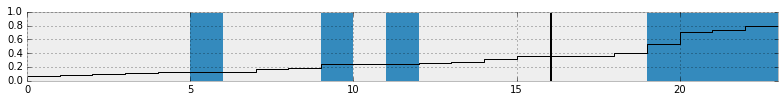

In [60]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space (or grey bars for the optimistic readers) denote non-defects.  As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.  


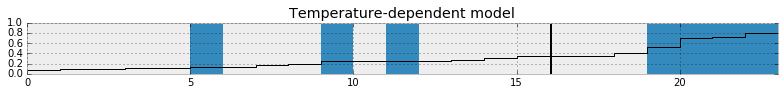

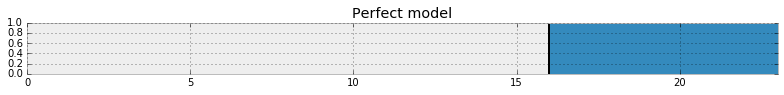

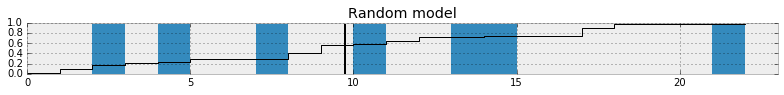

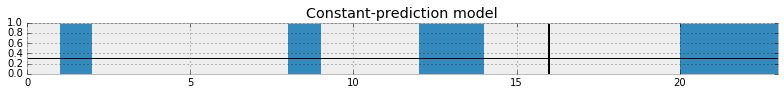

In [61]:
plt.figure(figsize=(11., 1.25))

# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# constant model
constant_prob = 7./23*np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

The perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure. Of course the perfect model is only for demonstration, and we cannot infer any scientific inference from it.

##### Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

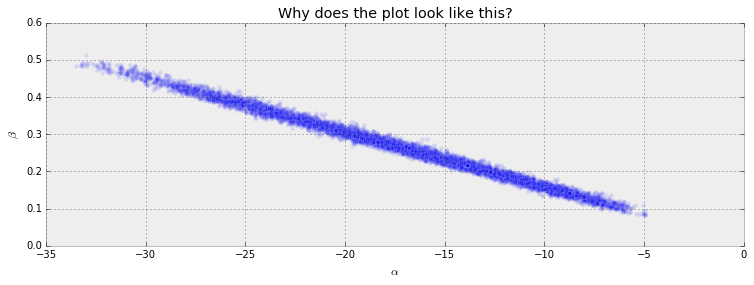

In [62]:
#type your code here.
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

### References

-  [1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.
-  [2] German Rodriguez. Datasets. In WWS509. Retrieved 30/01/2013, from <http://data.princeton.edu/wws509/datasets/#smoking>.
-  [3] McLeish, Don, and Cyntha Struthers. STATISTICS 450/850 Estimation and Hypothesis Testing. Winter 2012. Waterloo, Ontario: 2012. Print.
-  [4] Fonnesbeck, Christopher. "Building Models." PyMC-Devs. N.p., n.d. Web. 26 Feb 2013. <http://pymc-devs.github.com/pymc/modelbuilding.html>.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.
- [6] S.P. Brooks, E.A. Catchpole, and B.J.T. Morgan. Bayesian animal survival estimation. Statistical Science, 15: 357–376, 2000
- [7] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.
- [8] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.